# Cleaning and Preprocessing

### Imports

https://github.com/sanjeevai/disaster-response-pipeline/blob/master/models/train_classifier.py

In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
import wordcloud
import time
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from glob import glob

In [2]:
def make_cloud(X):
    '''
    Uses X value of data, which should be text columns
    '''

    wc = wordcloud.WordCloud(max_words=50, 
                             width=700, 
                             height=400, 
                             background_color='white',
                            )

    

    cloud = wc.generate(X.str.cat())

    return cloud.to_image()



## Import the data

## To Do for this section:


3. Make the data loader function agnostic to the input, with uniform output
4. Create database connection function to be called if `source == 'database'`

In [3]:
subreddit_list = ['css', 'html', 'javascript', 'php', 'perl', 'java', 'datascience', 'machinelearning', 'etl', 'python']

In [1]:
def data_selector(subreddit_list, source):
    '''Finds data for subreddits from selected source.
       
    Source: scrape
        Scrape each subreddit in the list now.
        Returns DataFrame
        
    Source: csv
        CSVs for subreddits in the 'scraped_subreddits' directory
        Prints subreddits with no CSV files
        Returns DataFrame
        
    Source: mongo
        Creates connection to Mongo DB
        Queries DB for subreddits
        Returns DataFrame
        
    Source: sqlite3
        Creates connection to SQLite DB
        Queries DB for subreddits
        Returns DataFrame
        
    Source: postgres
        Creates connection to Postgres DB
        Queries DB for subreddits
        Returns DataFrame
        
    Source: mysql
        Creates connection to Mysql DB
        Queries DB for subreddits
        Returns DataFrame
    '''

    if source == 'scrape':
        scrape = Scraper()
        df = scrape.scrape_subreddit(subreddit_list)
        return df

    # should I make this a function?  or is that unnecessary abstraction?
    if source == 'csv':
        df = pd.DataFrame()
        trimmed_list = []
        for sub in subreddit_list:
            csv_files = sorted(glob(f'../scraped_subreddits/*{sub}*.csv'))
            if len(csv_files) > 0:
                trimmed_list.append(sub)
                for csv_file in csv_files:
                    data = pd.read_csv(csv_file)
                    df = pd.concat([df, data], ignore_index=True)
            else:
                print(f'No data for {sub}')
        return df

    if source == 'mongo':
        database = Mongo()
        return database.create_connection()


        
    if source == 'sqlite':
        database = Sqlite()
        return database.create_connection()
        
        


    if source == 'postgres':
        database = Postgres()
        return database.create_connection()
    
    
    
    if source == 'mysql':
        database = Mysql()
        return database.create_connection()

In [6]:
def subreddit_encoder(df):
    '''Encodes each subreddit in the dataframe to numeric as 'sub_code' '''
    topic_dict = {}
    for index, subreddit in enumerate(trimmed_list):
        topic_dict.update({subreddit: index})
        df['sub_code'] = df['subreddit'].map(topic_dict)
    print(f'Topic dict to make sure: {topic_dict}')
    return df

In [5]:
df = data_selector(subreddit_list, 'csv')

,title,subreddit
0,Grid layout on larger screens,css
1,Is it possible to 'access' a grid that is not ...,css
2,Should 0fr be explicitly forbidden as a value ...,css
3,Flexbox questions regarding horizontal display,css
4,Simple CSS Image Clip Path Hover Animation,css
...,...,...
3611,"Think Philosophically, If you're struggling to...",python
3612,Run Application with Voice Command using Python,python
3613,"For a person coming from javascript, what are ...",python
3614,I programmed a Genetic Tree Generator and Arti...,python


In [7]:
# is this bad?  is this making a copy of a slice?
df = subreddit_encoder(df)

{'css': 0, 'html': 1, 'java': 2, 'python': 3}

In [8]:
df

,title,subreddit,sub_code
0,Grid layout on larger screens,css,0
1,Is it possible to 'access' a grid that is not ...,css,0
2,Should 0fr be explicitly forbidden as a value ...,css,0
3,Flexbox questions regarding horizontal display,css,0
4,Simple CSS Image Clip Path Hover Animation,css,0
...,...,...,...
3611,"Think Philosophically, If you're struggling to...",python,3
3612,Run Application with Voice Command using Python,python,3
3613,"For a person coming from javascript, what are ...",python,3
3614,I programmed a Genetic Tree Generator and Arti...,python,3


In [9]:
X = df['title']
y = df['sub_code']

# Most Words

Using CountVectorizer here to get a word count of all the words in the subreddits in order to visualize them.  
*Note*  
This should be available after fitting model, but I could not figure completely out the convoluted method to get to the items through the pipeline, grid, best_estimator, steps, etc...

In [10]:
my_stops = ENGLISH_STOP_WORDS

In [11]:
len(my_stops)

318

In [12]:
my_stops = my_stops.union(trimmed_list)

In [13]:
len(my_stops)

322

In [14]:
my_stops = my_stops.union(['using', 'help', 'new'])

In [15]:
len(my_stops)

325

In [16]:
cv = CountVectorizer(stop_words=my_stops, min_df=5)

features = pd.DataFrame(cv.fit_transform(df['title']).toarray(),
                        columns=cv.get_feature_names())

In [17]:
features.head()

,10,100,11,12,13,14,16,19,20,2019,...,write,writing,written,wrong,wrote,xml,year,years,youtube,zoom
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [19]:
base_common = features.sum().sort_values(ascending=False).head(20)

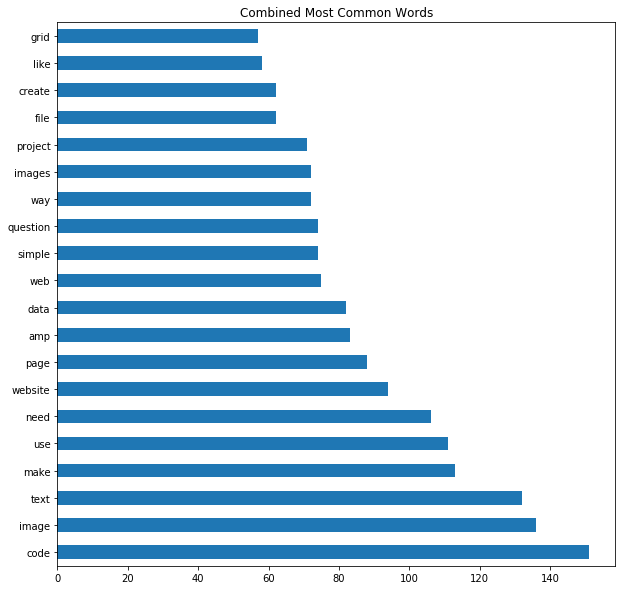

In [20]:
plt.figure(figsize=(10,10))
plt.title('Combined Most Common Words')
base_common.plot.barh();

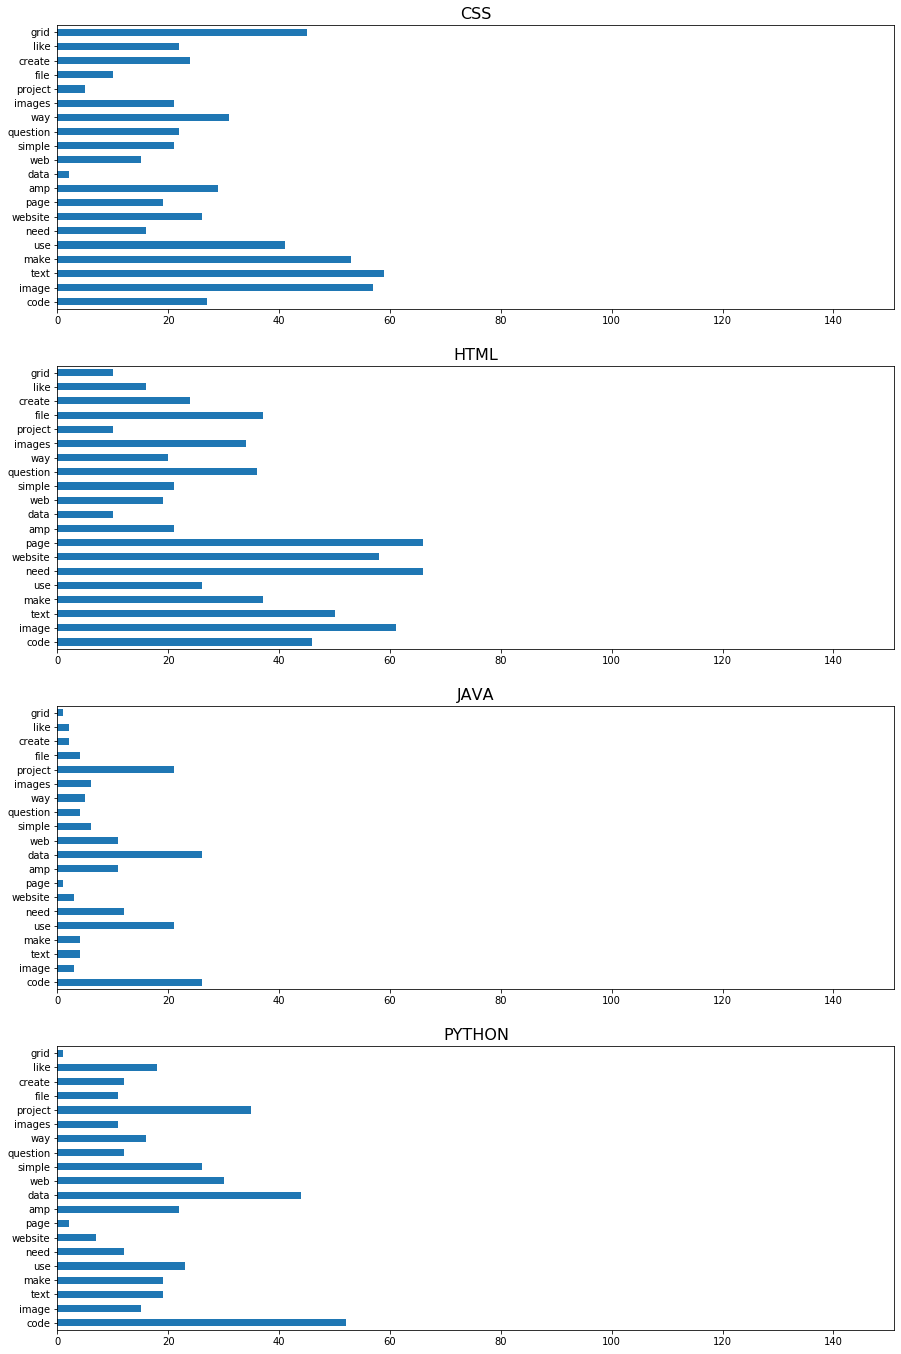

In [21]:
fig, ax = plt.subplots(ncols=1, nrows=len(trimmed_list), figsize=(15,6*len(trimmed_list)))

for subplot_idx, sub in enumerate(trimmed_list):
    topic_features = features.loc[df['subreddit'] == sub, :]
    topic_features_to_plot = topic_features[base_common.index].sum()
    
    topic_features_to_plot.plot(kind='barh', ax=ax[subplot_idx])
    max_occurence = features.sum().max()
    ax[subplot_idx].set_xlim(0,max_occurence)
    ax[subplot_idx].set_title(topic.upper(), fontsize=16)

## ToDo for this section

1. make each of these functions only take two 

In [ ]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15,6))
sci[base_common.index].sum().plot.barh(ax=ax1, title='Science', color='navy')
ax1.set_xlim(0,2800)
ax2.set_xlim(0,2800)
tech[base_common.index].sum().plot.barh(ax=ax2, title='Technology', color='orange');

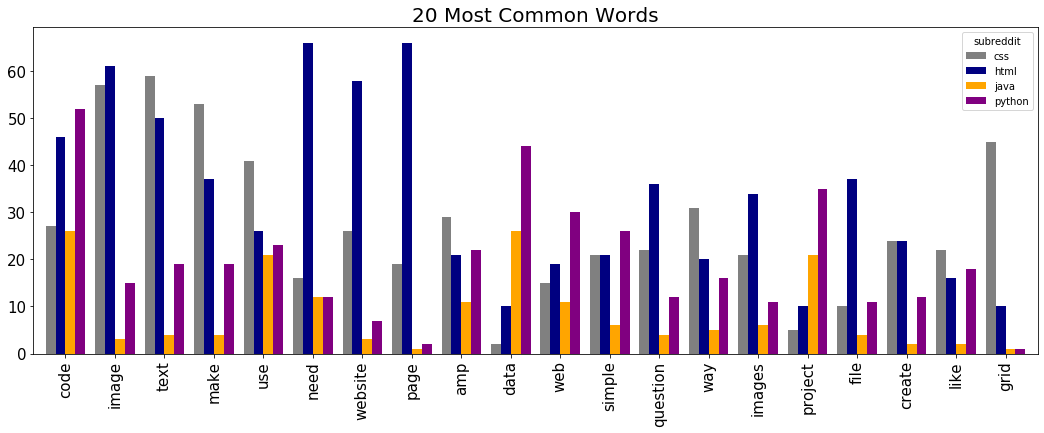

In [24]:
fig, ax = plt.subplots(figsize=(18,6))


groups = features.groupby(df['subreddit']).sum()[base_common.index].T.head(20)
plt.title('20 Most Common Words', fontsize=20)

groups.plot.bar(
                ax=ax,
                width=.8,
                # set style for colors instead of have to choose individually
                color=['gray','navy','orange','purple','red'],
                fontsize=15,
                );

# Word Clouds!!!

### Entire dataset

In [ ]:
make_cloud(X)

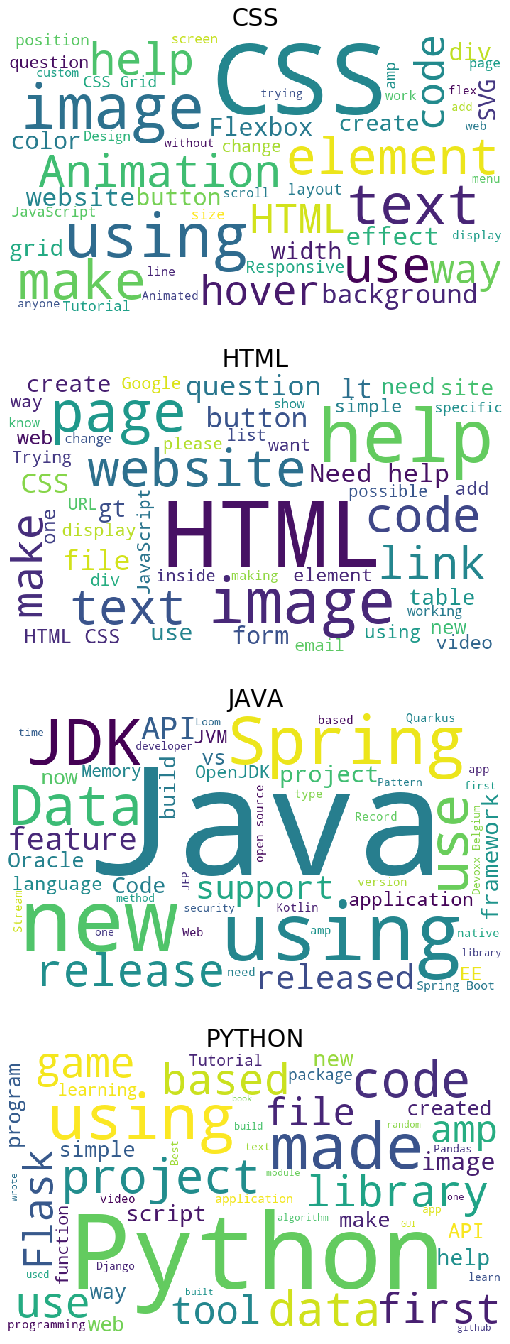

In [23]:
fig = plt.figure(figsize=(14, 6*len(trimmed_list)))
for i, sub in enumerate(trimmed_list):
    ax = fig.add_subplot(len(trimmed_list),1,i+1)
    cloud = make_cloud(X=df[df['subreddit'] == sub]['title'])
    

    ax.set_title(topic.upper(), fontdict={'fontsize': 24})
    ax.imshow(cloud)
    ax.axis('off')


## Baseline

In [25]:
df['subreddit'].value_counts(normalize=True)

html      0.269358
css       0.258296
python    0.252765
java      0.219580
Name: subreddit, dtype: float64

## Train/Test Split

In [26]:


X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=7)

---

# Logistic Regression Classifier

## Pipeline and GridSearchCV

In [27]:
lr_pipe = Pipeline([('count_vec', TfidfVectorizer()), ('lr', LogisticRegression())])

pipe_params = {
                'count_vec__max_features': [5000],
                'count_vec__max_df': [.3,.4,.5],
                'count_vec__ngram_range': [(1,2)],
                'count_vec__stop_words': [my_stops],
                'count_vec__min_df': [4,5,6],
                'lr__penalty': ['l1'],
                'lr__C': [1]
                }

In [28]:
lr_grid = GridSearchCV(lr_pipe, param_grid=pipe_params, cv=5, verbose=1, n_jobs=-1)

lr_grid.fit(X_train, y_train);

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    2.5s finished
/Users/chris/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/chris/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


## Scoring

In [30]:

print(lr_grid.best_score_)

0.6150442477876106


In [31]:
lr_grid.score(X_train, y_train)

0.7109144542772862

In [32]:
lr_grid.score(X_test, y_test)

0.5807522123893806

## To Do for this section

1. Confusion Matrix for all selected Topics
2. Make a function that will compare all topics in 1x1 fasion, find combinatorics or whatever Python library
3. Output each of the comparisons if a list of more than 2.

## Confusion Matrix

In [33]:
lr_predictions = lr_grid.predict(X_test)

In [34]:
lr_cm = confusion_matrix(y_test, lr_predictions)

In [38]:
lr_confusion_df = pd.DataFrame(lr_cm, columns=topics, index=topics)

lr_confusion_df

,css,html,java,python
css,127,58,8,52
html,46,125,4,56
java,6,9,117,61
python,19,35,25,156


In [ ]:
tn, fp, fn, tp = lr_cm.ravel()

### Specificity

In [ ]:
lr_spec = tn / (tn + fp)
lr_spec

### Sensitivity/Recall

In [ ]:
lr_sens = tp / (tp +fn)
lr_sens

### ROC AUC Score

In [ ]:
lr_auc = roc_auc_score(y_test, lr_predictions)
lr_auc

### ROC AUC Curve

In [ ]:
lr_probs = lr_grid.predict_proba(X_test)[:,1]

In [ ]:
# not multiclass
lr_fpr, lr_tpr, lr_thresholds = roc_curve(y_test, lr_probs)

In [ ]:
plt.figure(figsize=(10, 7))
plt.plot(lr_fpr, lr_tpr, label=f'ROC curve (area = {lr_auc})', color='r', marker='D')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate (1 - Specificity)', size=16)
plt.ylabel('True Positive Rate (Sensitivity)', size=16)
plt.title('ROC Curve Logistic Regression', size=20)
plt.legend(fontsize=14);

# Histograms!

In [ ]:
# Create figure.
plt.figure(figsize = (10,7))

# Create histogram of observations.
plt.hist(lr_probs, bins=25, color='b')

# Label axes.
plt.title('Distribution of P(Outcome = 1)', fontsize=22)
plt.ylabel('Frequency', fontsize=18)
plt.xlabel('Predicted Probability that Outcome = 1', fontsize=18);

In [ ]:
# Create figure.
plt.figure(figsize = (10,7))

# Create two histograms of observations.
hst0 = plt.hist(lr_probs[y_test == 0],
         bins=25,
         color='b',
         alpha = 0.6,
         label='Technology',)

hst1 = plt.hist(lr_probs[y_test == 1],
         bins=25,
         color='orange',
         alpha = 0.6,
         label='Science')

# Add vertical line at P(Outcome = 1) = 0.5.
plt.vlines(x=0.5,
           ymin = 0,
           ymax = max(hst1[0].max(), hst0[0].max()), # Max of the two highest respective hist values
           color='r',
           linestyle = '--')

# Label axes.
plt.title('Distribution of P(Science)', fontsize=22)
plt.ylabel('Frequency', fontsize=18)
plt.xlabel('Predicted Probability', fontsize=18)

# Create legend.
plt.legend(fontsize=20);

# Thanks to Matt Brems for the colorful graphs! :)

In [ ]:
lr_feats = lr_grid.best_estimator_.named_steps['tfidf'].get_feature_names()

lr_catcher = lr_grid.best_estimator_.named_steps['lr']


plt.figure(figsize=(16, 12))
plt.title('Feature Importance (Coefficients)', fontsize=20)
plt.ylabel('Features', fontsize=18)
plt.xlabel('(Abs) Coefficients', fontsize=18)

coef_df = pd.DataFrame(lr_catcher.coef_, columns=lr_feats).T
coef_df['abs_coef'] = coef_df[0].abs()
coef_df.sort_values('abs_coef', ascending=False)[0].head(15).plot(kind='barh');

# coef_kill = coef_df.sort_values('abs_coef', ascending=False)[0].head(500).index

# coef_kill


# my_stops.extend(coef_kill)